In [1]:
import numpy as np, agama
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import astropy.units as u
import os

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

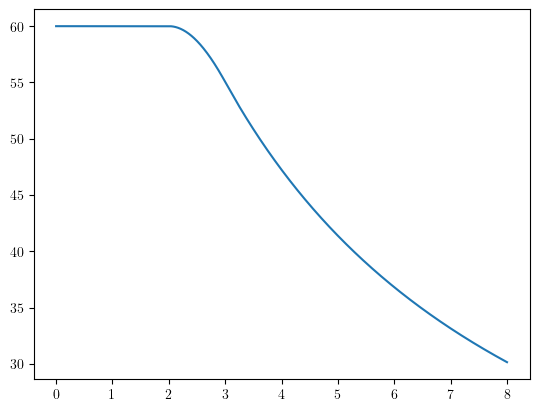

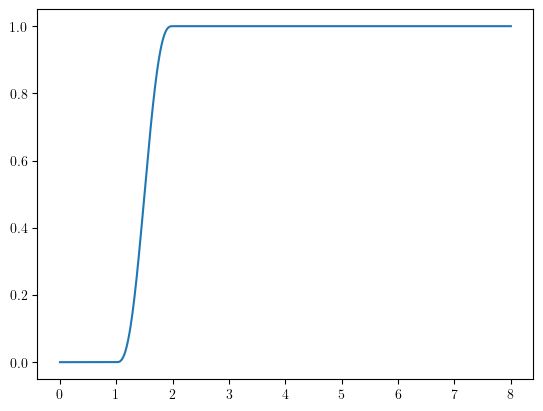

In [3]:
'''Create barred potential'''

# Function to calculate relative bar strength
def calc_bar_frac(t, t0, t1):
    xi = 2*(t - t0)/(t1 - t0) - 1
    bar_frac = np.clip(3/16*xi**5 - 5/8*xi**3 + 15/16*xi + 1/2, 0, 1)

    return bar_frac

from scipy.integrate import quad

def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters
t0 = 1  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Bar potential parameters
# t0 = 0     # Bar start time
# tf = -5   # End of simulation

Omega_b_f = 35 # Final pattern speed (in km/s/kpc)
# Omega_b_f = 30
eta = 0.003

# Potential parameters
R_sun = 8.178
#vcirc_sun = 236.9
#M20 = 1.91

# Array of times for potential creation
bartime = np.linspace(0, tf, 1001)

Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

for i in range(len(bartime)):
    Omega_b[i] = calc_Omega_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)

# Omega_b = Omega_b_f / (1 + eta*Omega_b_f*bartime)
# phi_b = 1/eta * np.log(1 + eta*Omega_b_f*bartime)
bar_frac = calc_bar_frac(bartime, t0, t1)

plt.plot(bartime, Omega_b)
plt.show()
plt.close()

plt.plot(bartime, bar_frac)


In [4]:
'''Load potentials'''

agama_pot_path = 'agama_potentials/'

pot_axi_Hunter_path = 'MWPotentialHunter24_axi.ini'
pot_bar_Hunter_path = 'MWPotentialHunter24_full.ini'
pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'
pot_nonaxi_path = 'MWPotentialHunter24_nonaxi.ini'

pot_axi_Hunter = agama.Potential(file=agama_pot_path+pot_axi_Hunter_path)
pot_bar_Hunter = agama.Potential(file=agama_pot_path+pot_bar_Hunter_path)
pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path)
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)
pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

pot_nonaxi = agama.Potential(pot_bar_baryon, pot_axi_baryon_neg)


32.50270855904658


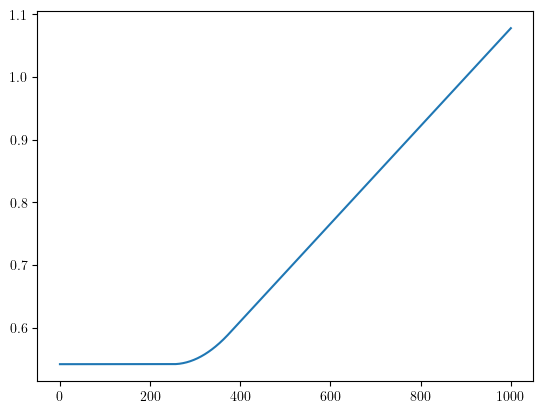

In [5]:
'''Make slowing barred potential'''

from scipy.optimize import fsolve

# First construct axisymmetric potential from baryonic Hunter24 potential + custom NFW
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)


# def make_potential(Omega_b_f, eta, t_f=-4):

#     bartime = np.linspace(tf, 0, 1001)

#     Omega_b = Omega_b_f / (1 + eta*Omega_b_f*bartime)
#     phi_b = 1/eta * np.log(1 + eta*Omega_b_f*bartime)
    
#     S = Omega_b_f/Omega_b
#     A = S
    
#     plt.plot(bartime, Omega_b)
#     plt.show()
#     plt.close()

#     plt.plot(bartime, S)
#     plt.show()
#     plt.close()

#     # Load full, scaled, rotated baryonic potential
#     pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
#     # And the axisymmetrised, scaled baryonic potential with equal but negative mass
#     pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

#     # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
#     # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
#     pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

#     return pot


# Then make full time-dependent potential with growing and slowing bar
def make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present):
    
    S = Omega_b_present/Omega_b
    A = bar_frac * S

    plt.plot(S)

    # Load full, scaled, rotated baryonic potential
    pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
    # And the axisymmetrised, scaled baryonic potential with equal but negative mass
    pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

    # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
    # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
    pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

    return pot

# Make custom potential
#pot_axi = make_pot(vcirc_sun, M20, pot_axi_baryon)

# Or use Hunter+24 potential
pot_axi = pot_axi_Hunter

# Select pattern speed at which to match Hunter bar length
Omega_b_present = calc_Omega_b(8*0.9, Omega_b_1, eta, t0, t1, t2, tf)

print(Omega_b_present)

pot_slow = make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present)



In [6]:
#%%

'''Import GC catalogue'''

import astropy.coordinates as coord

# Choose potential
agama_pot_path = 'agama_potentials/'#'/data/amd206/test/envs/py38_2/lib/python3.8/site-packages/agama/data/'
# pot = agama.Potential(agama_pot_path+'MWPotential2014_mod.ini')
# pot = agama.Potential(agama_pot_path+'Portail17_axi.ini')

GC_catalogue = np.loadtxt(datapath+'GC_catalogue.txt', dtype=str)

GC_names = GC_catalogue[:,0]

ra_GC = GC_catalogue[:,1].astype(float)
dec_GC = GC_catalogue[:,2].astype(float)
distance_GC = GC_catalogue[:,3].astype(float)
pmra_GC = GC_catalogue[:,9].astype(float)
pmdec_GC = GC_catalogue[:,10].astype(float)
vlos_GC = GC_catalogue[:,5].astype(float)

# Retrieve uncertainties for GCs
disterr = GC_catalogue[:,4].astype(float)
vloserr = GC_catalogue[:,6].astype(float)
pmraerr = GC_catalogue[:,12].astype(float)
pmdecerr = GC_catalogue[:,13].astype(float)

galcen_v_sun = np.array([11.1, 250.24, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

R_sun = 8.2


coords_GC = coord.SkyCoord(ra=ra_GC*u.deg, dec=dec_GC*u.deg, distance=distance_GC*u.kpc, pm_ra_cosdec=pmra_GC*u.mas/u.yr, pm_dec=pmdec_GC*u.mas/u.yr, radial_velocity=vlos_GC*u.km/u.s)

# galcen_v_sun = np.array([11.1, 250.24, 7.25])*u.km/u.s#np.array([9.3, 251.5, 8.59])*u.km/u.s#(12.9, 245.6, 7.78)

coords_GC = coords_GC.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_GC = np.array([coords_GC.x.value, coords_GC.y.value, coords_GC.z.value, coords_GC.v_x.value, coords_GC.v_y.value, coords_GC.v_z.value]).T

# Convert to coordinate system where Sun is at x=8kpc, Galactic rotation in +y direction
ic_GC = ic_GC*np.array([-1, 1, 1, -1, 1, 1])

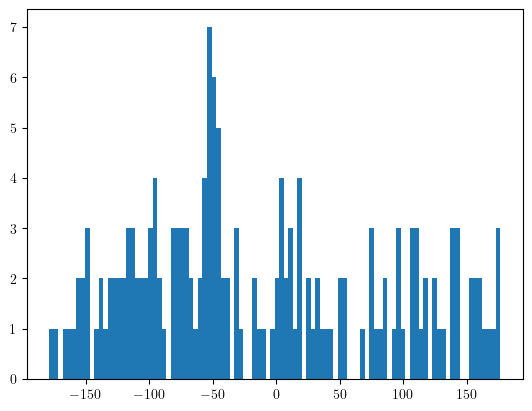

In [8]:
#%%

'''Calculate GC quantities'''

coords_GC_gal = coords_GC.transform_to('galactic')

l_GC = coords_GC_gal.l.value
l_GC = (l_GC + 180)%360 - 180
b_GC = coords_GC_gal.b.value


bar_angle = 30 * np.pi/180

phi_GC = (np.arctan2(ic_GC[:,1], ic_GC[:,0]) - bar_angle + np.pi) % (2 * np.pi) - np.pi

plt.hist(phi_GC*180/np.pi, bins=100)
plt.show()
plt.close()

r_GC = np.linalg.norm(ic_GC[:,0:3], axis=1)
R_GC = np.linalg.norm(ic_GC[:,0:2], axis=1)

R_hat = ic_GC[:,0:3] * [1, 1, 0] / R_GC[:,None]
vR_GC = (ic_GC[:,3:6] * R_hat).sum(axis=1)
vphi_GC = np.linalg.norm(ic_GC[:,3:6] - vR_GC[:,None]*R_hat - ic_GC[:,3:6]*[0,0,1], axis=-1)

r_hat = ic_GC[:,0:3] / r_GC[:,None]
vr_GC = (ic_GC[:,3:6] * r_hat).sum(axis=1)

# Rotate GCs into coordinate system with x-axis along bar's major axis
rot_mat = np.array([[np.cos(bar_angle), np.sin(bar_angle), 0], [-np.sin(bar_angle), np.cos(bar_angle), 0], [0, 0, 1]])

pos_GC = np.einsum('ij,kj->ki', rot_mat, ic_GC[:,0:3])
vel_GC = np.einsum('ij,kj->ki', rot_mat, ic_GC[:,3:6])

ic_GC = np.hstack((pos_GC, vel_GC))


# Calculate energy
E_GC = 0.5 * (ic_GC[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic_GC[:,0:3])

# Calculate angular momentum
L_GC = np.cross(ic_GC[:,0:3], ic_GC[:,3:6], axis=1)

# z-component
L_z_GC = L_GC[:,2]

# Magnitude

L_mag_GC = np.linalg.norm(L_GC, axis=-1)


# '''Calculate actions'''

# af = agama.ActionFinder(pot)
# act_GC, ang_GC, freq_GC = af(ic_GC, angles=True)

In [9]:
'''Modify list of GC names'''
# Modify names from original catalogue to cross-match
GC_names_mod = np.array(GC_names)
for i in range(len(GC_names)):
    
    name = GC_names[i]
    
    name_list = list(name)
    
    for j in range(len(name_list)):
        print(j)
        if name_list[j]=='_':
            name_list[j] = ' '
            
    for j in range(len(name_list)):    
        if np.isin(name_list[j], ['M', 'P']):
            name_list = name_list[j:]
            
            if name_list[0] == 'M':
                del name_list[1]
            
            print(name_list)
            
            break
        
    
    name = ''.join(name_list)
    
    if name == 'NGC 104 47Tuc':
        name = '47 Tuc'
    
    GC_names_mod[i] = name

print(GC_names_mod)

0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
0
1
2
3
4
['P', 'a', 'l', ' ', '1']
0
1
2
3
['M', '1']
0
1
2
3
4
5
6
7
0
1
2
3
4
['P', 'a', 'l', ' ', '2']
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
['M', '7', '9']
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
0
1
2
3
4
['P', 'y', 'x', 'i', 's']
0
1
2
3
4
5
6
7
0
1
2
0
1
2
3
4
['P', 'a', 'l', ' ', '3']
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
['P', 'a', 'l', ' ', '4']
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
['M', '6', '8']
0
1
2
3
4
5
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
['M', '5', '3']
0
1
2
3
4
5
6
7
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
['M', '3']
0
1
2
3
4
5
6
7
0
1
2
3
['M', '4']
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
0
1
2
3
4
5
6
['M', 'n', 'o', 'z', ' ', '1']
0
1
2
3
4
5
6
7
0
1
2
3
4
['P', 'a', 'l', ' ', '5']
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
['M', '5']
0


In [10]:
'''Integrate orbits of selected GCs in rotating barred potential'''

def test_part_sim(ic, pot, time, trajsize=2, Omega=0, timestart=0):
    
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega, time=time, trajsize=trajsize, timestart=timestart)
    
    ts = o[:,0][0]
    trajs = np.stack(o[:,1]).transpose((1,0,2))

    return trajs, ts

In [11]:
'''Generate a stellar stream from a GC'''

from astropy.constants import G

# Mass of stream progenitor
M_s = 7.79e5

# Scale radius
a_s = 4.32e-3

# Velocity dispersion of released particles
sigma_s = 1

# Position of release compared to Lagrange point
lambda_source = 1.2

# Number of particles stripped per timestep
# Needs to be even
strip_rate = 100

# t_f = -5

trajsize = 1001

def lagrange_cloud_strip(fc, potential, trajsize=trajsize, Omega=0, rewind=True):#int(np.round((Tfinal-Tbegin)/Tstep)+1)

    # Integrate orbit of progenitor
    
    if rewind == True:
        prog_orbit = agama.orbit(ic=fc, potential=potential, timestart=tf, time=-tf, trajsize=trajsize, Omega=Omega)
        
        times = np.flip(prog_orbit[0])
        trajsize = len(times)
        prog_traj = np.flip(prog_orbit[1], axis=0)
        prog_traj_array = np.hstack((np.array([times]).T, prog_traj))
    
    else:
        prog_orbit = agama.orbit(ic=fc, potential=potential, timestart=0, time=tf, trajsize=trajsize, Omega=Omega)
        
        times = prog_orbit[0]
        trajsize = len(times)
        prog_traj = prog_orbit[1]
        prog_traj_array = np.hstack((np.array([times]).T, prog_traj))

    #print(prog_traj_array.shape)
    
    # np.savetxt('prog_traj_'+str(os.getpid())+'.txt', prog_traj_array[:, 0:4])
    
    # Construct potential of progenitor and combine with total potential
    # potprog = agama.Potential(type='Plummer', mass=M_s, scaleRadius=a_s, center=prog_traj_array)#'prog_traj_'+str(os.getpid())+'.txt')
    # pottot_prog = agama.Potential(potential, potprog)
    
    # Calculate angular speed of progenitor (in units of km/s/kpc)
    r_prog = np.linalg.norm(prog_traj[:,0:3], axis=1)
    L_prog = np.linalg.norm(np.cross(prog_traj[:,0:3], prog_traj[:,3:6]), axis=1)
    Omega_prog = L_prog / r_prog**2
    
    # Calculate 2nd derivative of external potential
    force, deriv = potential.forceDeriv(prog_traj[:,0:3], t=times)
    
    # Calculate Hessian matrix
    Hessian = np.zeros((trajsize, 3, 3))
    Hessian[:, 0, :] = -np.array([deriv[:, 0], deriv[:, 3], deriv[:, 5]]).T
    Hessian[:, 1, :] = -np.array([deriv[:, 3], deriv[:, 1], deriv[:, 4]]).T
    Hessian[:, 2, :] = -np.array([deriv[:, 5], deriv[:, 4], deriv[:, 2]]).T
    
    r_hat = prog_traj[:, 0:3] / r_prog[:,None]
    d2Phi_d2r = np.einsum('ki,kij,kj->k', r_hat, Hessian, r_hat)
    
    r_t_max = 1 # Cap on tidal radius (used to replace nans)
    
    r_t = np.nan_to_num( (((G * M_s / (Omega_prog**2 - d2Phi_d2r))*u.Msun/(u.km/u.s/u.kpc)**2)**(1/3)).to(u.kpc).value, nan=r_t_max)
    
    r_t = np.minimum(r_t, r_t_max)    # Limit r_t to chosen value
    
    source_coords_in = prog_traj[:, 0:3] - lambda_source * r_t[:, None] * r_hat
    source_coords_out = prog_traj[:, 0:3] + lambda_source * r_t[:, None] * r_hat
    
    prog_velocity_r = np.sum(prog_traj[:, 3:6]*r_hat, axis=1)
    prog_velocity_tan = prog_traj[:, 3:6] - prog_velocity_r[:, None] * r_hat
    
    source_velocity_tan_in = prog_velocity_tan * (1 - 0.5 * r_t / r_prog)[:, None]
    source_velocity_tan_out = prog_velocity_tan * (1 + 0.5 * r_t / r_prog)[:, None]
    
    source_velocity_in = prog_velocity_r[:, None] * r_hat + source_velocity_tan_in
    source_velocity_out = prog_velocity_r[:, None] * r_hat + source_velocity_tan_out
    
    source_coords = np.zeros((len(source_coords_in)*2, 3))
    source_coords[::2] = source_coords_in
    source_coords[1::2] = source_coords_out
    
    source_velocity = np.zeros((len(source_velocity_in)*2, 3))
    source_velocity[::2] = source_velocity_in
    source_velocity[1::2] = source_velocity_out
    
    ic_source_coords = np.repeat(source_coords, strip_rate/2, axis=0)
    ic_source_velocities = np.repeat(source_velocity, strip_rate/2, axis=0)
    
    np.random.seed(0)
    ic = np.hstack((ic_source_coords, ic_source_velocities)) + np.hstack((np.zeros((trajsize*strip_rate, 3)), np.random.randn(trajsize*strip_rate, 3)*sigma_s))
    
    start_times = np.repeat(times, strip_rate)
    
    trajsizes = np.repeat(np.arange(trajsize, 0, -1), strip_rate)

    result = agama.orbit(ic=ic, potential=potential, timestart=start_times, time=tf-start_times, trajsize=trajsizes, Omega=Omega)[:-strip_rate]
    
    trajs = np.zeros((trajsize, len(result), 6))
    for part_index in range(len(result)):
        trajsize_part = trajsizes[part_index]
        traj_part = trajs[:, part_index, :]
        
        traj_part[0:-trajsize_part, :] = prog_traj[0:-trajsize_part]
        traj_part[-trajsize_part:, :] = result[:, 1][part_index]
        
        # trajs[0:-trajsizes[part_index], part_index, :] = prog_traj[0:-trajsizes[part_index]]
        # trajs[-trajsizes[part_index]:, part_index, :] = result[:, 1][part_index]
    
    #print('5 = ', time.process_time()-start_prog)
    
    return trajs, prog_traj, r_t

[498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.08677259 498527.08677259 498527.08677259
 498527.08677259 498527.0

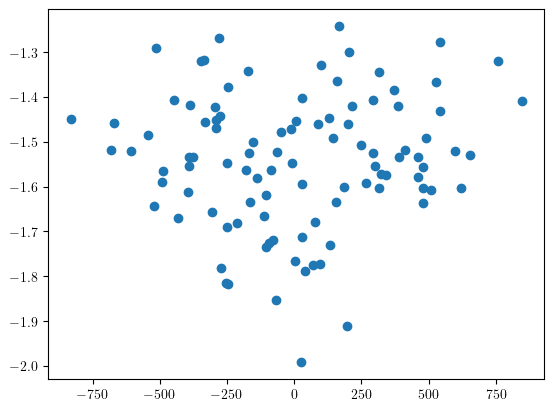

In [14]:
# Generate ICs from smooth GC distribution function

# Gaussian profile
sigma = 2.7
Nbody = 100
density_poh = agama.Density(type='spheroid', mass=5e7, beta=0, gamma=0, outerCutoffRadius=np.sqrt(2)*sigma, cutoffStrength=2)
df_poh = agama.DistributionFunction(type='quasispherical', density=density_poh, potential=pot_axi)
ic_smooth, mass = agama.GalaxyModel(pot_axi, df_poh).sample(Nbody)

# Calculate E and Lz
E_smooth = 0.5 * (ic_smooth[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic_smooth[:,0:3])
Lz_smooth = np.cross(ic_smooth[:,0:3], ic_smooth[:,3:6])[:,2]

plt.scatter(Lz_smooth, E_smooth/1e5)

print(mass)

In [15]:
'''Generate tails of streams in axisymmetric, steadily rotating barred, and decelerating barred potentials'''

from matplotlib.patches import Circle

# Simulation paramters
M_s = 7.79e5
a_s = 4.32e-3
sigma_s = 1
lambda_source = 1.2
strip_rate = 2
# t_f = -5
trajsize = 1001 #1001

# bartime = np.linspace(t_f, 0, trajsize)

# Initial conditions
ic = ic_smooth
N_GC = len(ic)

trajs_axi_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))
trajs_bar_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))
trajs_slow_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))

prog_traj_axi_array = np.zeros((N_GC, trajsize, 6))
prog_traj_bar_array = np.zeros((N_GC, trajsize, 6))
prog_traj_slow_array = np.zeros((N_GC, trajsize, 6))

for i in range(N_GC):#len(ic_GC)):
    # fc = ic_GC[GC_names_mod == '47 Tuc'][0]
    # if E_GC[i] < 0:
    fc = ic[i]
    # trajs_axi, prog_traj_axi, r_t_axi = lagrange_cloud_strip(fc, potential=pot_axi, trajsize=trajsize)
    # trajs_bar, prog_traj_bar, r_t_bar = lagrange_cloud_strip(fc, potential=pot_bar, trajsize=trajsize, Omega=Omega_b_f)
    trajs_slow, prog_traj_slow, r_t_slow = lagrange_cloud_strip(fc, potential=pot_slow, trajsize=trajsize, rewind=False)

    # trajs_axi_array[i] = trajs_axi
    # trajs_bar_array[i] = trajs_bar
    trajs_slow_array[i] = trajs_slow

    # prog_traj_axi_array[i] = prog_traj_axi
    # prog_traj_bar_array[i] = prog_traj_bar
    prog_traj_slow_array[i] = prog_traj_slow
        

2002 orbits complete (172.4 orbits/s)
2002 orbits complete (248.1 orbits/s)
2002 orbits complete (199.9 orbits/s)
2002 orbits complete (121.7 orbits/s)
2002 orbits complete (197.4 orbits/s)
2002 orbits complete (151.1 orbits/s)
2002 orbits complete (314.4 orbits/s)
2002 orbits complete (185.6 orbits/s)
2002 orbits complete (207.2 orbits/s)
2002 orbits complete (170.8 orbits/s)
2002 orbits complete (239.6 orbits/s)
2002 orbits complete (107.7 orbits/s)
2002 orbits complete (157.8 orbits/s)
2002 orbits complete (148.1 orbits/s)
2002 orbits complete (335.8 orbits/s)
2002 orbits complete (309.6 orbits/s)
2002 orbits complete (123 orbits/s)
2002 orbits complete (190.5 orbits/s)
2002 orbits complete (246.1 orbits/s)
2002 orbits complete (138.1 orbits/s)
2002 orbits complete (251.7 orbits/s)
2002 orbits complete (200.3 orbits/s)
2002 orbits complete (264.3 orbits/s)
2002 orbits complete (222.4 orbits/s)
2002 orbits complete (204.8 orbits/s)
2002 orbits complete (214.3 orbits/s)
2002 orbits co

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2002 orbits complete (108.5 orbits/s)
2002 orbits complete (431.8 orbits/s)
2002 orbits complete (150.3 orbits/s)
2002 orbits complete (254.1 orbits/s)
2002 orbits complete (325 orbits/s)
2002 orbits complete (315.7 orbits/s)
2002 orbits complete (169.2 orbits/s)
2002 orbits complete (279.5 orbits/s)
2002 orbits complete (227 orbits/s)
2002 orbits complete (176.2 orbits/s)
2002 orbits complete (243.1 orbits/s)
2002 orbits complete (166.2 orbits/s)
2002 orbits complete (241.7 orbits/s)
2002 orbits complete (213.6 orbits/s)
2002 orbits complete (2.753 orbits/s)
2002 orbits complete (205.9 orbits/s)
2002 orbits complete (160.5 orbits/s)
2002 orbits complete (117.2 orbits/s)
2002 orbits complete (158.8 orbits/s)
2002 orbits complete (286 orbits/s)
2002 orbits complete (179.7 orbits/s)
2002 orbits complete (136 orbits/s)
2002 orbits complete (220.3 orbits/s)
2002 orbits complete (244.8 orbits/s)
2002 orbits complete (183.2 orbits/s)
2002 orbits complete (233.5 orbits/s)
2002 orbits complete

In [16]:
'''Save simulation'''

np.save(simpath+'trajs_slow_array', trajs_slow_array)
np.save(simpath+'prog_traj_slow_array', prog_traj_slow_array)

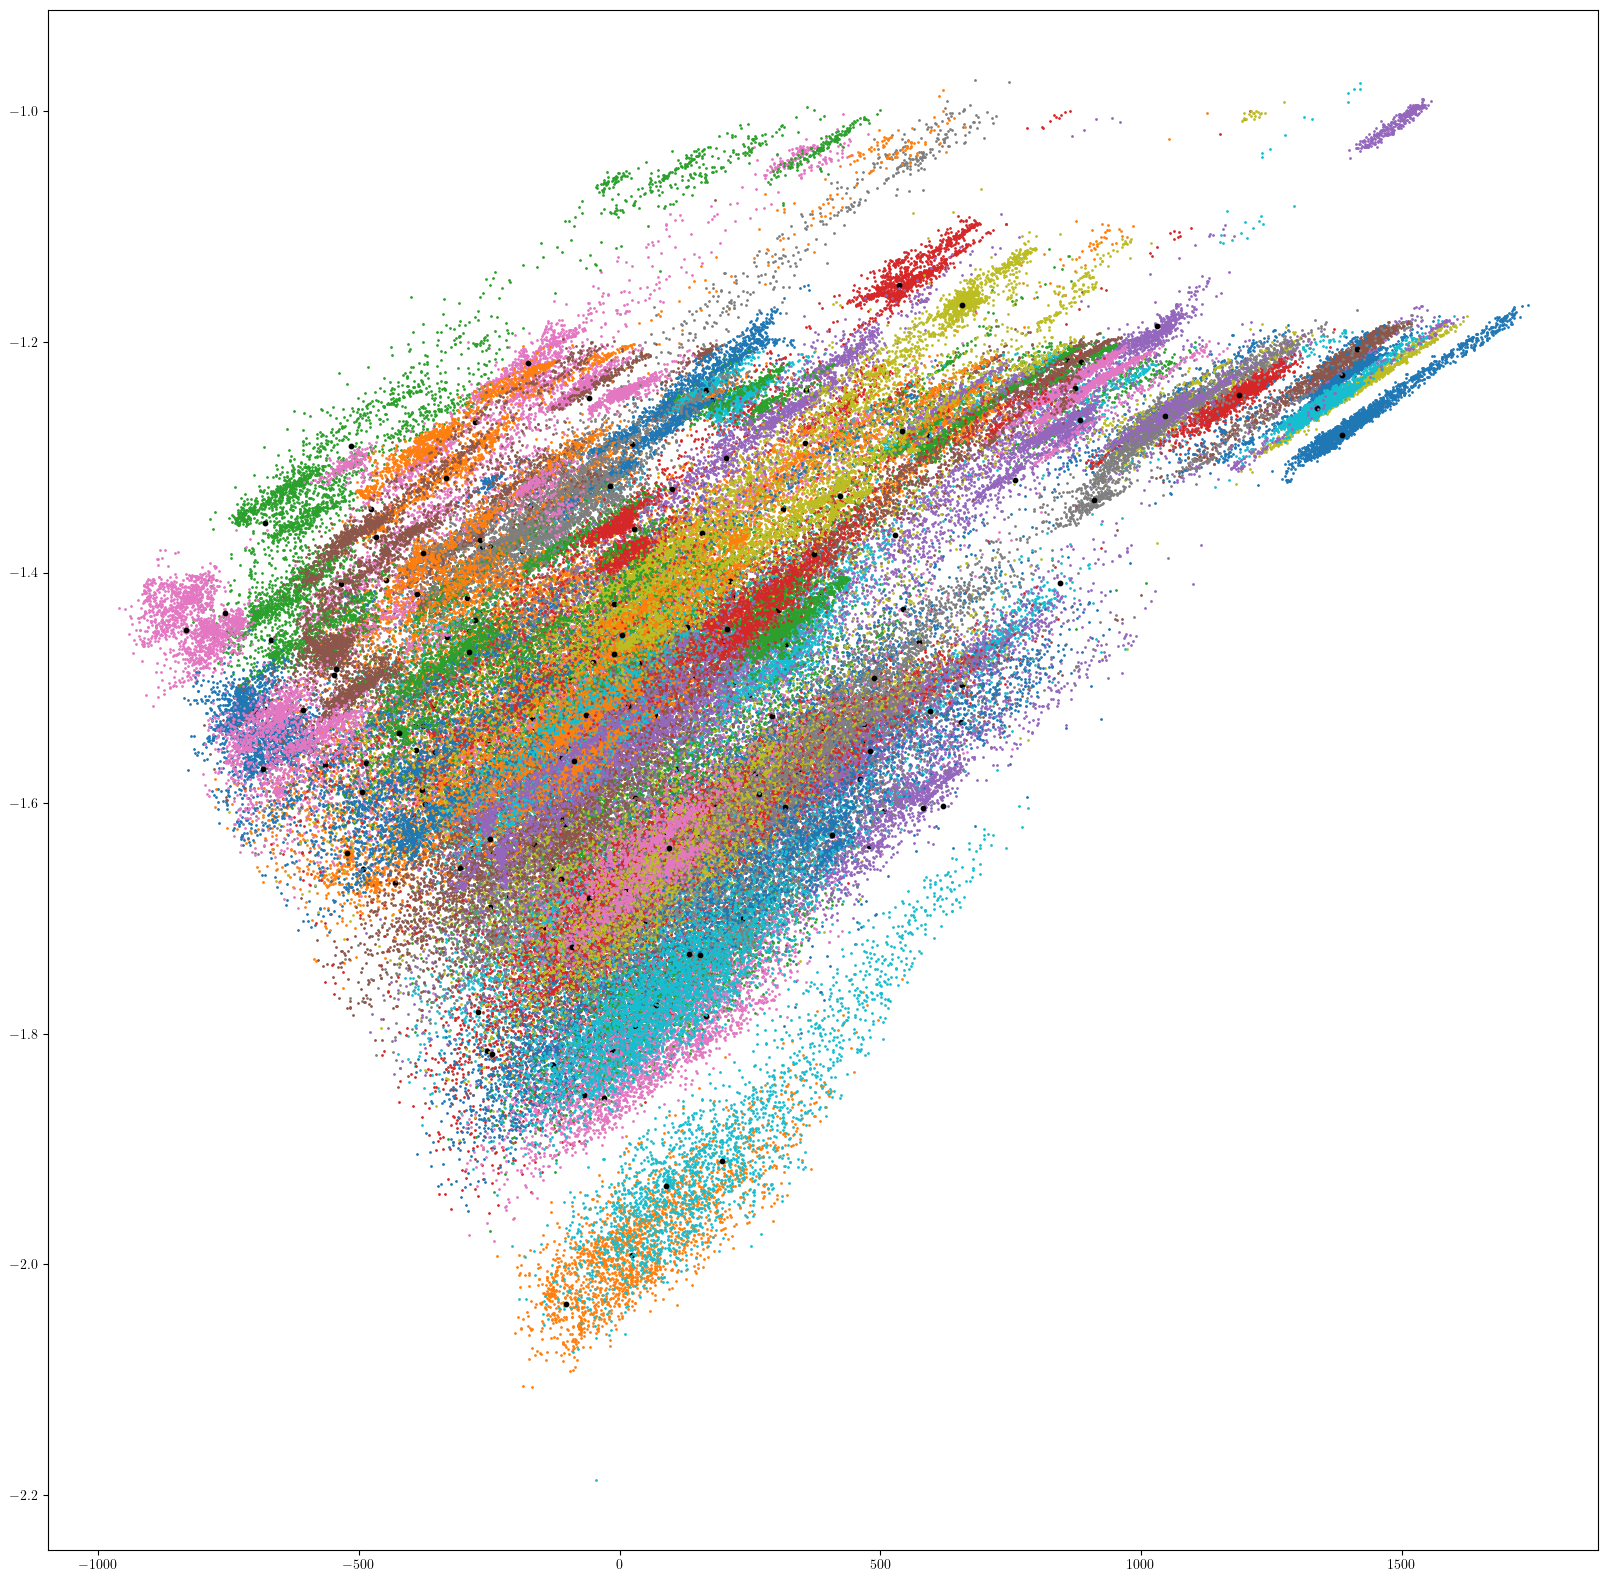

In [17]:
'''Calculate energies, pericentres, apocentres, etc.'''

E_prog_array = np.zeros(N_GC)
Lz_prog_array = np.zeros(N_GC)

sigma_E_axi_array = np.zeros(N_GC)
sigma_E_bar_array = np.zeros(N_GC)
sigma_E_slow_array = np.zeros(N_GC)

sigma_HJ_axi_array = np.zeros(N_GC)
sigma_HJ_bar_array = np.zeros(N_GC)
sigma_HJ_slow_array = np.zeros(N_GC)

peri_array = np.zeros(N_GC)
apo_array = np.zeros(N_GC)

freq_eigvals_axi_array = np.zeros((N_GC, 3))
freq_eigvals_bar_array = np.zeros((N_GC, 3))
freq_eigvals_slow_array = np.zeros((N_GC, 3))

ang_eigvals_axi_array = np.zeros((N_GC, 3))
ang_eigvals_bar_array = np.zeros((N_GC, 3))
ang_eigvals_slow_array = np.zeros((N_GC, 3))


index_list = np.linspace(0, 1000, 11).astype(int)

fig, ax = plt.subplots(figsize=(20,20), sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0)

index = -1

for i in range(N_GC):
    # if E_GC[i] < -1.5e5:
    trajs_axi = trajs_axi_array[i]
    # trajs_bar = trajs_bar_array[i]
    trajs_slow = trajs_slow_array[i]

    prog_traj_axi = prog_traj_axi_array[i]
    # prog_traj_bar = prog_traj_bar_array[i]
    prog_traj_slow = prog_traj_slow_array[i]

    E_axi = 0.5*(trajs_axi[-1,:,3:6]**2).sum(axis=-1) + pot_axi.potential(trajs_axi[-1,:,0:3])
    Lz_axi = np.cross(trajs_axi[-1,:,0:3], trajs_axi[-1,:,3:6])[:,2]
    HJ_axi = E_axi - Omega_b_f*Lz_axi

    sigma_E_axi_array[i] = np.std(E_axi[0::2])
    sigma_HJ_axi_array[i] = np.std(HJ_axi[0::2])

    # E_bar = 0.5*(trajs_bar[-1,:,3:6]**2).sum(axis=-1) + pot_bar.potential(trajs_bar[-1,:,0:3])
    # Lz_bar = np.cross(trajs_bar[-1,:,0:3], trajs_bar[-1,:,3:6])[:,2]
    # HJ_bar = E_bar - Omega_b_f*Lz_bar

    # sigma_E_bar_array[i] = np.std(E_bar[0::2])
    # sigma_HJ_bar_array[i] = np.std(HJ_bar[0::2])

    E_slow = 0.5*(trajs_slow[index,:,3:6]**2).sum(axis=-1) + pot_axi.potential(trajs_slow[index,:,0:3])
    Lz_slow = np.cross(trajs_slow[index,:,0:3], trajs_slow[index,:,3:6])[:,2]
    HJ_slow = E_slow - Omega_b_f*Lz_slow

    # sigma_E_slow_array[i] = np.std(E_slow)
    # sigma_HJ_slow_array[i] = np.std(HJ_slow)

    E_prog = 0.5*(prog_traj_slow[-1,3:6]**2).sum(axis=-1) + pot_axi.potential(prog_traj_slow[-1,0:3])
    Lz_prog = np.cross(prog_traj_slow[-1,0:3], prog_traj_slow[-1,3:6])[2]
    # r_prog = np.linalg.norm(prog_traj_axi[:,0:3], axis=-1)
    # peri_array[i] = np.min(r_prog)
    # apo_array[i] = np.max(r_prog)

    # _, ang_axi, freq_axi = af(trajs_axi[-1,0::2], angles=True)
    # # _, ang_bar, freq_bar = af(trajs_bar[-1,0::2], angles=True)
    # _, ang_slow, freq_slow = af(trajs_slow[-1], angles=True)


    # freq_cov_axi = np.cov(freq_axi[~np.isnan(freq_axi[:,0])], rowvar=False)
    # # freq_cov_bar = np.cov(freq_bar[~np.isnan(freq_bar[:,0])], rowvar=False)
    # freq_cov_slow = np.cov(freq_slow[~np.isnan(freq_slow[:,0])], rowvar=False)

    # freq_eigvals_axi_array[i] = np.sort(np.linalg.eig(freq_cov_axi)[0])
    # # freq_eigvals_bar_array[i] = np.sort(np.linalg.eig(freq_cov_bar)[0])
    # freq_eigvals_slow_array[i] = np.sort(np.linalg.eig(freq_cov_slow)[0])

    # ang_cov_axi = np.cov(ang_axi[~np.isnan(ang_axi[:,0])], rowvar=False)
    # # ang_cov_bar = np.cov(ang_bar[~np.isnan(ang_bar[:,0])], rowvar=False)
    # freq_cov_slow = np.cov(freq_slow[~np.isnan(freq_slow[:,0])], rowvar=False)

    # ang_eigvals_axi_array[i] = np.sort(np.linalg.eig(ang_cov_axi)[0])
    # # ang_eigvals_bar_array[i] = np.sort(np.linalg.eig(ang_cov_bar)[0])
    # freq_eigvals_slow_array[i] = np.sort(np.linalg.eig(freq_cov_slow)[0])

    # ax.scatter(Lz_axi, E_axi/1e5, s=0.5, alpha=0.5)
    # axs[0].scatter(Lz_axi, E_axi/1e5, s=0.5, c='tab:blue', alpha=0.1)
    ax.scatter(Lz_slow, E_slow/1e5, s=1, alpha=1)
    # ax.scatter(Lz_slow[-2], E_slow[-2]/1e5, s=1, alpha=1)
    ax.scatter(Lz_smooth[i], E_smooth[i]/1e5, c='k', s=10)
    ax.scatter(Lz_prog, E_prog/1e5, c='k', s=10)

plt.show()
plt.close()


In [18]:
'''Plot 2D histogram in E-Lz space of stripped stars only'''

index = 1000

ts = np.linspace(0, tf, trajsize)

print(calc_Omega_b(ts[index], Omega_b_1, eta, t0, t1, t2, tf))

E_array = np.zeros(trajs_axi_array.shape[0:3])
Lz_array = np.zeros(trajs_axi_array.shape[0:3])

for i in range(N_GC):
    trajs_axi = trajs_axi_array[i]
    # trajs_bar = trajs_bar_array[i]
    trajs_slow = trajs_slow_array[i]

    for index in range(len(ts)):
        E_slow = 0.5*(trajs_slow[index,:,3:6]**2).sum(axis=-1).flatten() + pot_axi.potential(trajs_slow[index,:,0:3])
        Lz_slow = np.cross(trajs_slow[index,:,0:3], trajs_slow[index,:,3:6])[:,2]

        E_array[i,index] = E_slow
        Lz_array[i,index] = Lz_slow

E_flat = E_array.reshape(trajs_axi_array.shape[1], trajs_axi_array.shape[0]*trajs_axi_array.shape[2])
Lz_flat = Lz_array.reshape(trajs_axi_array.shape[1], trajs_axi_array.shape[0]*trajs_axi_array.shape[2])


30.15075376884422


(1001, 200000)


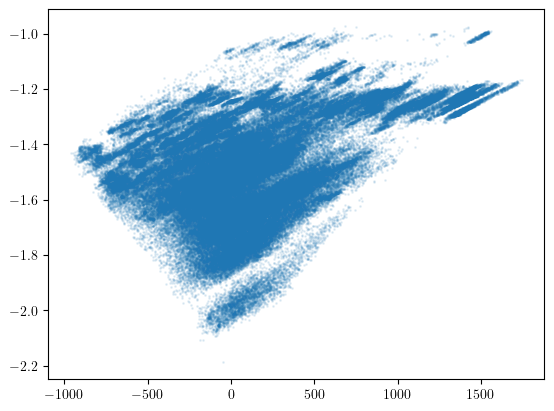

In [ ]:

E_transpose = E_array.transpose(1,0,2)#.reshape(E_array.shape[0], E_array.shape[1]*E_array.shape[2])
Lz_transpose = Lz_array.transpose(1,0,2)#.reshape(Lz_array.shape[0], Lz_array.shape[1]*Lz_array.shape[2])

E_flat = E_transpose.reshape(E_transpose.shape[0], E_transpose.shape[1]*E_transpose.shape[2])
Lz_flat = Lz_transpose.reshape(Lz_transpose.shape[0], Lz_transpose.shape[1]*Lz_transpose.shape[2])

print(E_flat.shape)

index = 

plt.scatter(Lz_flat[index], E_flat[index]/1e5, s=1, alpha=0.1)

plt.show()
plt.close()


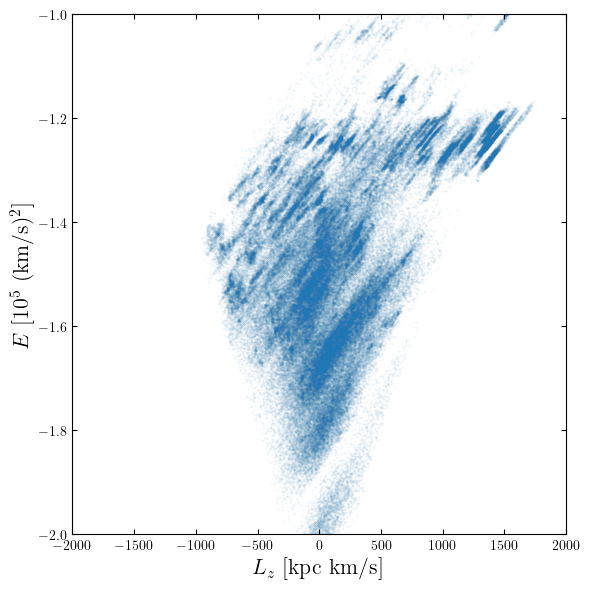

In [20]:
'''Make animation of streams in E-Lz space'''

from matplotlib.animation import FuncAnimation

# Step 1: Prepare the data
# Generate random data points for the example
x = Lz_flat[0,:]
y = E_flat[0,:]/1e5

snap = 0

# Step 2: Create the figure and scatter plot
fig, ax = plt.subplots(figsize=(6,6))

scatter = ax.scatter(x, y, s=0.1, alpha=0.1)

# Set the plot limits
Lz_max = 2000
E_min = -2
E_max = -1
ax.set_xlim(-Lz_max, Lz_max)
ax.set_ylim(E_min, E_max)

# Step 3: Define the update function
# snap = 0
def update(frame):
    global x, y, i
    # Update the data points (here we are just adding a small random value)
    # snap += 1 
    x = Lz_flat[frame,:]
    y = E_flat[frame,:] / 1e5
    # Update the scatter plot
    scatter.set_offsets(np.c_[x, y])
    
    return scatter,

ax.set_xlabel('$L_z$ [kpc km/s]', fontsize=16)
ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

# Step 4: Create the animation
# snap  = 0
ani = FuncAnimation(fig, update, frames=len(trajs_axi), interval=20, blit=True)

# Step 5: Display the animation
fig.set_tight_layout(True)

ani.save('GC_debris_bar.mp4', writer='ffmpeg', dpi=400)
plt.show()


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/1985078418.py:5: RuntimeWarning: invalid value encountered in divide
  plt.scatter(Lz_prog_array, E_prog_array/1e5, c=sigma_E_slow_array/sigma_E_axi_array, norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2), cmap='seismic')


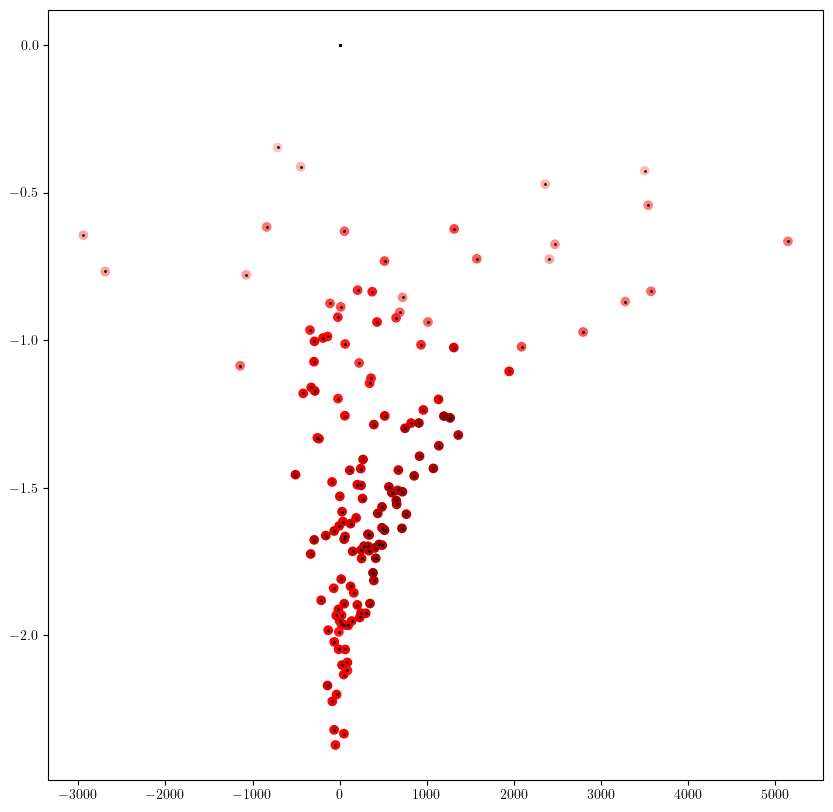

In [ ]:
# Plot energy dispersion vs orbital properties

fig, ax = plt.subplots(figsize=(10,10))
# plt.scatter(Lz_prog_array, E_prog_array/1e5, c=sigma_E_bar_array/sigma_E_axi_array, norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2), cmap='seismic')
plt.scatter(Lz_prog_array, E_prog_array/1e5, c=sigma_E_slow_array/sigma_E_axi_array, norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2), cmap='seismic')
plt.scatter(Lz_prog_array, E_prog_array/1e5, s=1, c='k')

# plt.scatter(peri_array, sigma_E_axi_array)
# plt.scatter(apo_array, sigma_E_bar_array/sigma_E_axi_array)

# print(peri_array)
# plt.xlim(0, 20)
# plt.ylim(0)

# print(peri_array[GC_names == 'Pal_5'])
# print(GC_names_mod[np.argmin(peri_array[peri_array>0])])

# print(GC_names)

# print(peri_array[GC_names=='NGC_1904_M_79'])

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/82137122.py:39: RuntimeWarning: invalid value encountered in scalar divide
  ecc = (apo-peri)/(apo+peri)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/82137122.py:41: RuntimeWarning: divide by zero encountered in log
  axs[0].scatter(np.exp(np.log(peri)+((coords_gal.l.value-coords_prog_gal.l.value+180)%360-180)/500), ecc+(coords_gal.b.value-coords_prog_gal.b.value)/1000, s=0.5, alpha=0.1)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/82137122.py:61: RuntimeWarning: invalid value encountered in scalar divide
  ecc = (apo-peri)/(apo+peri)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/82137122.py:63: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(np.exp(np.log(peri)+((coords_gal.l.value-coords_prog_gal.l.value+180)%360-180)/500), ecc+(coords_gal.b.value-coords_prog_gal.b.value)/1000, s=0.5, alpha=0.1)


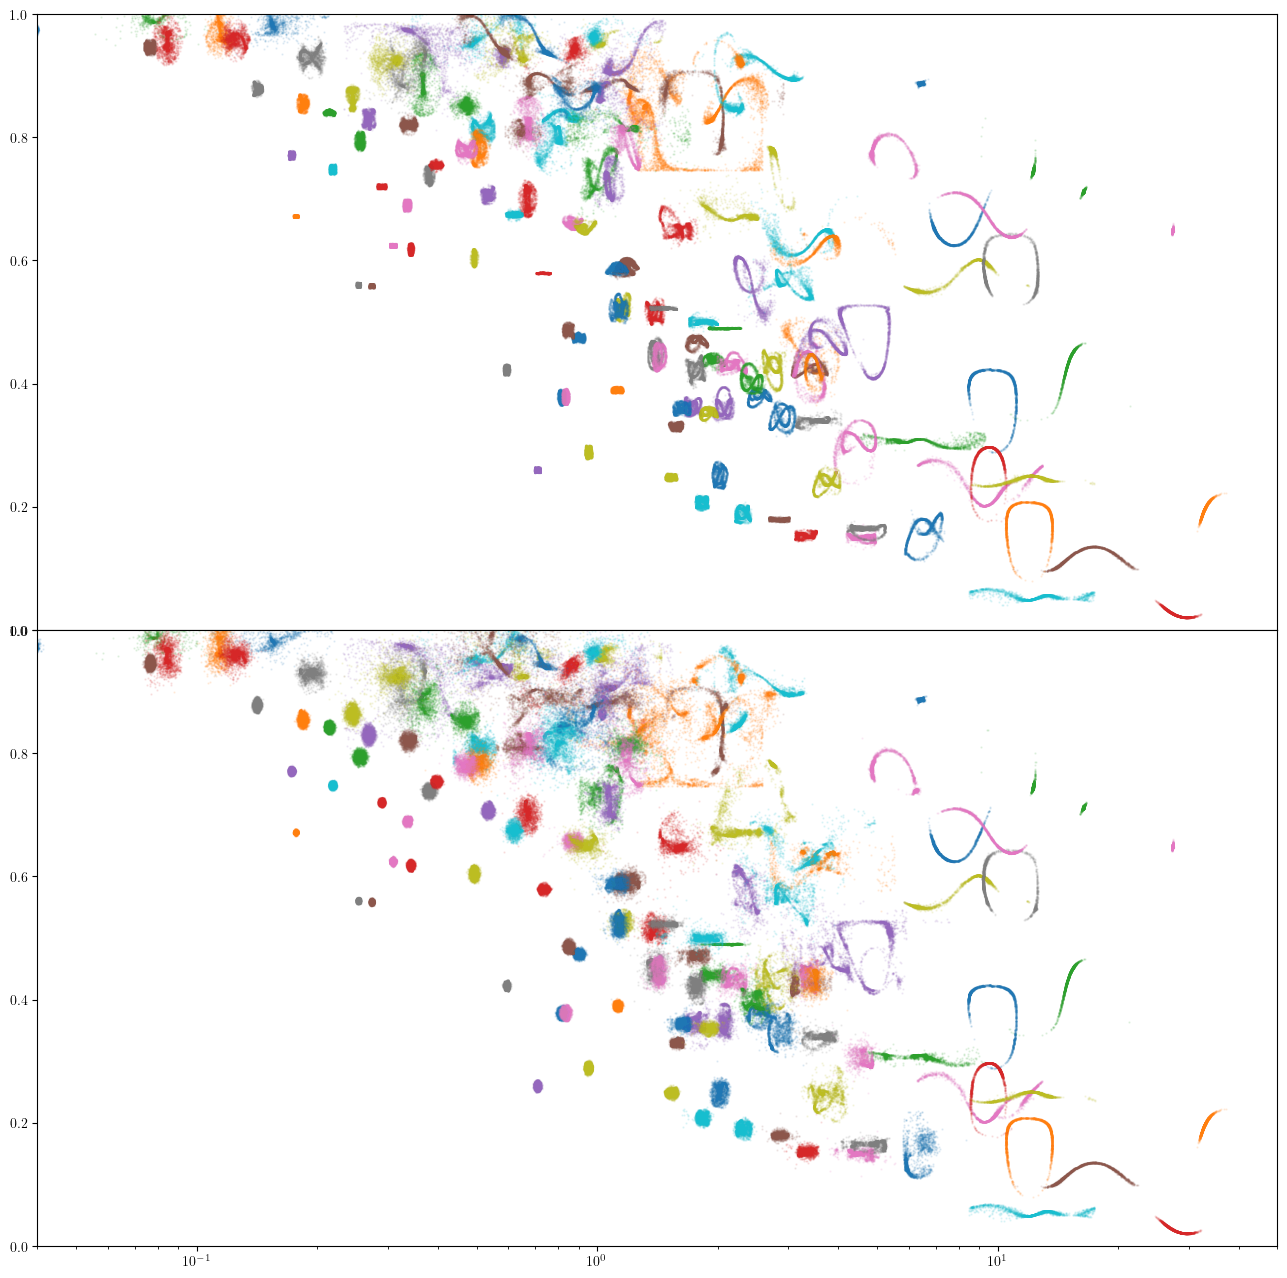

In [ ]:
'''Plot chosen streams on the sky'''

fig, axs = plt.subplots(2, figsize=(16,16))
plt.subplots_adjust(hspace=0)

for index in range(N_GC):

    trajs_axi = trajs_axi_array[index]
    trajs_bar = trajs_bar_array[index]
    trajs_slow = trajs_slow_array[index]

    E_bar = 0.5*(trajs_bar[-1,:,3:6]**2).sum(axis=-1) + pot_bar.potential(trajs_bar[-1,:,0:3])
    Lz_bar = np.cross(trajs_bar[-1,:,0:3], trajs_bar[-1,:,3:6])[:,2]

    # plt.scatter(Lz_bar, E_bar, s=1)

    prog_traj_axi = prog_traj_axi_array[index]
    prog_traj_bar = prog_traj_bar_array[index]
    prog_traj_slow = prog_traj_slow_array[index]

    rot_mat = np.array([[np.cos(-bar_angle), np.sin(-bar_angle), 0], [-np.sin(-bar_angle), np.cos(-bar_angle), 0], [0, 0, 1]])

    pos_stream = np.einsum('ij,kj->ki', rot_mat, trajs_axi[-1,:,0:3])
    pos_prog = np.einsum('ij,j->i', rot_mat, prog_traj_axi[-1,0:3])

    coords = coord.SkyCoord(x=-pos_stream[:,0]*u.kpc, y=pos_stream[:,1]*u.kpc, z=pos_stream[:,2]*u.kpc, frame=coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))
    coords = coords.transform_to('icrs')
    coords_gal = coords.transform_to('galactic')

    coords_prog = coord.SkyCoord(x=-pos_prog[0]*u.kpc, y=pos_prog[1]*u.kpc, z=pos_prog[2]*u.kpc, frame=coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))
    coords_prog = coords_prog.transform_to('icrs')
    coords_prog_gal = coords_prog.transform_to('galactic')

    ra_rel_cos_dec = ((coords.ra.value-coords_prog.ra.value+180)%360 - 180)*np.cos(coords.dec[-1])
    dec_rel = coords.dec.value-coords_prog.dec.value

    peri = peri_array[index]
    apo = apo_array[index]
    ecc = (apo-peri)/(apo+peri)

    axs[0].scatter(np.exp(np.log(peri)+((coords_gal.l.value-coords_prog_gal.l.value+180)%360-180)/500), ecc+(coords_gal.b.value-coords_prog_gal.b.value)/1000, s=0.5, alpha=0.1)



    pos_stream = np.einsum('ij,kj->ki', rot_mat, trajs_slow[-1,:,0:3])
    pos_prog = np.einsum('ij,j->i', rot_mat, prog_traj_slow[-1,0:3])

    coords = coord.SkyCoord(x=-pos_stream[:,0]*u.kpc, y=pos_stream[:,1]*u.kpc, z=pos_stream[:,2]*u.kpc, frame=coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))
    coords = coords.transform_to('icrs')
    coords_gal = coords.transform_to('galactic')

    coords_prog = coord.SkyCoord(x=-pos_prog[0]*u.kpc, y=pos_prog[1]*u.kpc, z=pos_prog[2]*u.kpc, frame=coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))
    coords_prog = coords_prog.transform_to('icrs')
    coords_prog_gal = coords_prog.transform_to('galactic')

    ra_rel_cos_dec = ((coords.ra.value-coords_prog.ra.value+180)%360 - 180)*np.cos(coords.dec[-1])
    dec_rel = coords.dec.value-coords_prog.dec.value

    peri = peri_array[index]
    apo = apo_array[index]
    ecc = (apo-peri)/(apo+peri)

    axs[1].scatter(np.exp(np.log(peri)+((coords_gal.l.value-coords_prog_gal.l.value+180)%360-180)/500), ecc+(coords_gal.b.value-coords_prog_gal.b.value)/1000, s=0.5, alpha=0.1)





    # ax.scatter(np.radians((coords_gal.l.value+180)%360-180), np.radians(coords_gal.b.value), s=0.5, alpha=0.1)
    # ax.text(np.radians((coords_prog_gal.l.value+180)%360-180), np.radians(coords_prog_gal.b.value), GC_names[index])
for ax in axs.flat:
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
# ax.axis('equal')
plt.show()



In [ ]:
# Simulation paramters
M_s = 7.79e5
a_s = 4.32e-3
sigma_s = 1
lambda_source = 1.2
strip_rate = 2
t_f = -1
trajsize = 4001 #1001

bartime = np.linspace(t_f, 0, trajsize)

fc = ic_GC[np.where(GC_names_mod=='M79')[0][0]]

trajs_bar, prog_traj_bar, r_t_bar = lagrange_cloud_strip(fc, potential=pot_axi, trajsize=trajsize, Omega=Omega_b_f)

1.1157342
-139.95640456330315
[0.21330267 0.21382785 0.21435074 ... 0.28712888 0.28724312 0.28735581]
8002 orbits complete (599.9 orbits/s)


0.006821751012736866


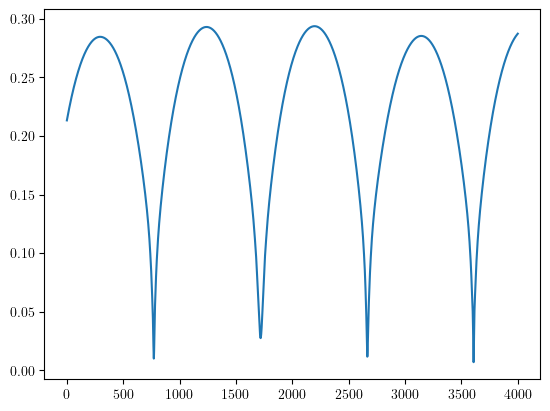

In [ ]:
plt.plot(r_t_bar)

print(np.min(r_t_bar))

In [ ]:
'''Load Andrae RGB sample'''

from astropy.io import fits
from astropy.table import Table

hdu_RGB = fits.open(datapath+'table_2_catwise.fits', memmap=True)
t_RGB = Table.read(hdu_RGB)

In [583]:
'''Transform and cut RGB sample data'''

coords_RGB = coord.SkyCoord(ra=t_RGB['ra']*u.deg, dec=t_RGB['dec']*u.deg, distance=1/t_RGB['parallax']*u.kpc, pm_ra_cosdec=t_RGB['pmra']*u.mas/u.yr, pm_dec=t_RGB['pmdec']*u.mas/u.yr, radial_velocity=t_RGB['radial_velocity']*u.km/u.s)

coords_RGB = coords_RGB.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_RGB = np.array([coords_RGB.x.value, coords_RGB.y.value, coords_RGB.z.value, coords_RGB.v_x.value, coords_RGB.v_y.value, coords_RGB.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic_RGB = ic_RGB*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn_RGB = t_RGB['parallax']/t_RGB['parallax_error']
dist_RGB = 1/t_RGB['parallax']
MH_RGB = t_RGB['mh_xgboost']
# logg = t_RGB['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn_RGB > parsn_min) * (dist_RGB < dist_max)

ic_RGB = ic_RGB[cut]
MH_RGB = MH_RGB[cut]

ra_RGB = t_RGB['ra'][cut]
dec_RGB = t_RGB['dec'][cut]

R_RGB = np.linalg.norm(ic_RGB[:,0:2], axis=1)
phi_RGB_sun = np.arctan2(ic_RGB[:,1], ic_RGB[:,0])
z_RGB = ic_RGB[:,2]

R_hat = ic_RGB[:,0:3] * [1, 1, 0] / R_RGB[:,None]
vR_RGB = (ic_RGB[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_RGB = (ic_RGB[:,3:6] * phi_hat).sum(axis=1)

Lz_RGB = R_RGB * vphi_RGB

E_RGB = 0.5 * (ic_RGB[:,3:6]**2).sum(axis=-1) + pot_axi.potential(ic_RGB[:,0:3])

act_RGB = af(ic_RGB)

Jz_RGB = act_RGB[:,1]

In [675]:
'''Cut out globular clusters, LMC, SMC'''

from astropy.coordinates import angular_separation

GC_catalogue = np.loadtxt(datapath+'GC_catalogue.txt', dtype=str)

ra_GC = GC_catalogue[:,1].astype(float)
dec_GC = GC_catalogue[:,2].astype(float)
dist_GC = GC_catalogue[:,3].astype(float)

GC_cut = np.ones(len(ra_RGB)).astype(bool)

min_ang_sep = 1
max_GC_dist = 15

for i in range(len(ra_GC)):
    
    if dist_GC[i] < max_GC_dist:
    # Use small angle approximation to calculate angular distance
        d_ra = ra_RGB - ra_GC[i]
        d_dec = dec_RGB - dec_GC[i]
        
        ang_sep = np.sqrt(d_dec**2 + np.cos(dec_GC[i]*np.pi/180)**2 * d_ra**2)
    
        GC_cut = GC_cut * (ang_sep > min_ang_sep)

103.44639245965149


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_48043/2427011833.py:26: RuntimeWarning: invalid value encountered in divide
  hist_unsharp = hist / hist_smooth


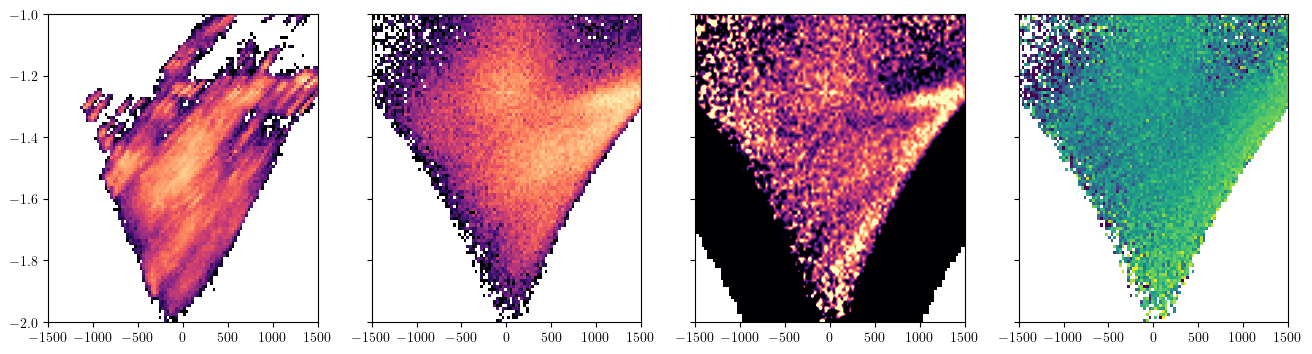

In [752]:
'''Plot E-Lz space for data, including colour-coded by metallicity'''

from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter

Lz_bins = np.linspace(-1500, 1500, 101)
E_bins = np.linspace(-2, -1, 101)
fig, axs = plt.subplots(1,4, figsize=(16,4), sharex=True, sharey=True)

cut = (MH_RGB < -1)* GC_cut

index = -1

hist, _, _ = np.histogram2d(Lz_flat[index], E_flat[index]/1e5, bins=(Lz_bins, E_bins))
axs[0].imshow(hist.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='magma')

# hist_smooth = gaussian_filter(hist, sigma=(0,10))
# hist_unsharp = hist/hist_smooth
# axs[1].imshow(hist_unsharp.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower', interpolation='none', norm=mcolors.CenteredNorm(vcenter=1, halfrange=2), cmap='Greys')

hist, _, _ = np.histogram2d(Lz_RGB[cut], E_RGB[cut]/1e5, bins=(Lz_bins, E_bins))
axs[1].imshow(hist.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='magma')

hist_smooth = gaussian_filter(hist, sigma=5)
# hist = gaussian_filter(hist, sigma=0.5)
hist_unsharp = hist / hist_smooth

# hist_unsharp = gaussian_filter(hist_unsharp, sigma=0.5)

axs[2].imshow(hist_unsharp.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower', interpolation='bilinear', norm=mcolors.CenteredNorm(vcenter=1, halfrange=0.5), cmap='magma')


hist, _, _, _ = binned_statistic_2d(Lz_RGB[cut], E_RGB[cut]/1e5, MH_RGB[cut], statistic='mean', bins=(Lz_bins, E_bins))
print(np.nanmedian(Jz_RGB[cut]))

axs[3].imshow(hist.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower', interpolation='none', vmin=-2, vmax=-1)

# axs[3].imshow(hist_smooth.T, extent=[Lz_bins[0], Lz_bins[-1], E_bins[0], E_bins[-1]], aspect='auto', origin='lower')



# for i in [-1.37, -1.32]:
#     axs[2].axline((0,i), slope=35.25/1e5, ls=':', c='w', zorder=0)

# axs[2].axvline(100, ls=':', c='w', zorder=0)
# axs[2].axvline(-400, ls=':', c='w', zorder=0)

# axs[2].axline((0,-1.3), slope=35/1e5, ls=':', c='tab:red')

for ax in axs.flat:
    ax.set_ylim(-2,-1)

plt.show()
plt.close()

1730
1538


(array([0.00650618, 0.00650618, 0.01301236, 0.01951854, 0.05855563,
        0.07807417, 0.09759271, 0.11711126, 0.23422251, 0.33832141,
        0.45543266, 0.52700065, 0.70266753, 0.61808718, 0.64411191,
        0.94990241, 1.06701366, 1.09303839, 1.53545869, 1.43786597]),
 array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
        -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ]),
 [<matplotlib.patches.Polygon at 0x3220aee10>])

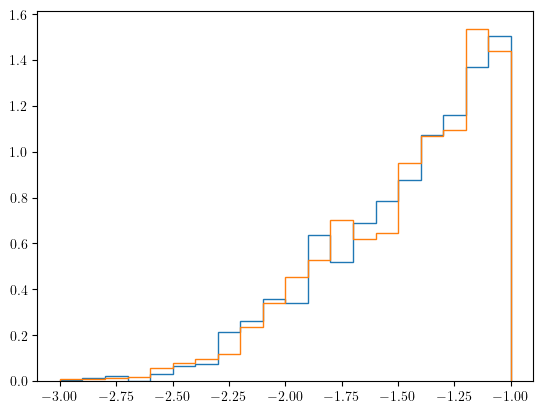

In [756]:
cut = (MH_RGB < -1)*GC_cut*(E_RGB > 35.25 * Lz_RGB - 1.37e5)*(E_RGB < 35.25 * Lz_RGB - 1.32e5)*(Lz_RGB > -400)*(Lz_RGB < 100)

plt.hist(MH_RGB[cut], bins=np.linspace(-3, -1, 21), histtype='step', density=True)

print(cut.sum())

cut = (MH_RGB < -1)*GC_cut*(E_RGB > 35.25 * Lz_RGB - 1.42e5)*(E_RGB < 35.25 * Lz_RGB - 1.37e5)*(Lz_RGB > -400)*(Lz_RGB < 100)

print(cut.sum())

plt.hist(MH_RGB[cut], bins=np.linspace(-3, -1, 21), histtype='step', density=True)

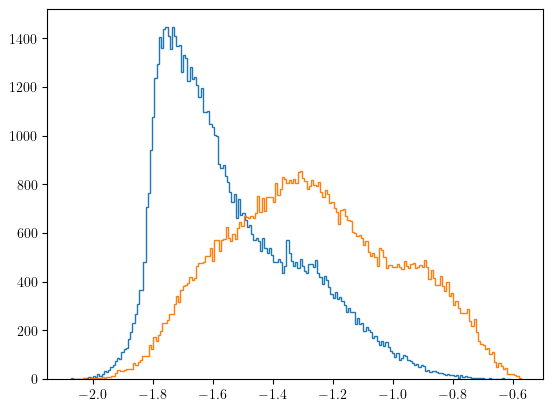

In [685]:

cut = (MH_RGB < -1)* GC_cut * E_RGB < -1.2e5

HJ_RGB = E_RGB - 35 * Lz_RGB
plt.hist(HJ_RGB[cut]/1e5, bins=200, histtype='step')

anti_HJ_RGB = E_RGB + 35 * Lz_RGB
plt.hist(anti_HJ_RGB[cut]/1e5, bins=200, histtype='step')

plt.show()
plt.close()
